In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import os
import copy as cp

from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt

import emcee
import corner

from catwoman.cat import Cat # need to fix weird importing
import ksz.analyse
import ksz.utils
import ksz.Pee
from ksz.parameters import *

In [4]:
plt.rc('font', family='serif')

### Sim 10842

This notebook serves as an introduction to parsing and manipulating data from the suite of LoReLi simulations. Manipulating the data requires the use and installation of two custom librairies, demonstrated here.  These librairies are very much a work in progress so please don't judge them too harshly!

First, we need to load the simulation products.

In [11]:
sim = Cat('10842', reinitialise_spectra=True)

Now if we want to compare with the Gorce 2022 model, then we want to load that module as well.

In [12]:
G22 = ksz.Pee.Gorce2022(sim.k, sim.z, sim.xe,
                              model_params=modelparams_Gorce2022, verbose=False)

In [20]:
fnums = sim.gen_filenums()

spectra = []

for fn in fnums:
    name = f'/Users/emcbride/ps_dtb/powerspectrum_electrons{fn}.dat'
    print(name)
    s = np.genfromtxt(name)
    spectra.append(s)

/Users/emcbride/ps_dtb/powerspectrum_electrons006.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons007.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons008.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons009.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons010.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons011.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons012.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons013.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons014.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons015.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons016.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons017.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons018.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons019.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons020.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons021.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons022.dat
/Users/emcbride/ps_dtb/powerspectrum_electrons023.dat
/Users/emcbride/ps_dtb/power

In [23]:
spectra[0][:,0]

array([ 0.0314    ,  0.0628    ,  0.0942    ,  0.1256    ,  0.15700001,
        0.18840001,  0.21980001,  0.25120001,  0.28260001,  0.31400001,
        0.34540001,  0.37680001,  0.40820001,  0.43960001,  0.47100002,
        0.50240002,  0.53380002,  0.56520002,  0.59660002,  0.62800002,
        0.65940002,  0.69080002,  0.72220002,  0.75360003,  0.78500003,
        0.81640003,  0.84780003,  0.87920003,  0.91060003,  0.94200003,
        0.97340003,  1.00480003,  1.03620003,  1.06760004,  1.09900004,
        1.13040004,  1.16180004,  1.19320004,  1.22460004,  1.25600004,
        1.28740004,  1.31880004,  1.35020005,  1.38160005,  1.41300005,
        1.44440005,  1.47580005,  1.50720005,  1.53860005,  1.57000005,
        1.60140005,  1.63280005,  1.66420006,  1.69560006,  1.72700006,
        1.75840006,  1.78980006,  1.82120006,  1.85260006,  1.88400006,
        1.91540006,  1.94680007,  1.97820007,  2.00960007,  2.04100007,
        2.07240007,  2.10380007,  2.13520007,  2.16660007,  2.19

In [34]:
averaged_bins = np.zeros_like(sim.Pee)

for i in range(sim.k.size-1):
    bin = sim.k[i]
    bin_edge = sim.k[i+1]
    for j in range(len(spectra)):
        k = spectra[j][:,0]
        Pee_raw = spectra[j][:,1]
        print(f'k={k}')
        ks = np.where((k >= bin) & (k < bin_edge))[0]
        print(f'There are {ks.size} bins in between {bin} + {bin_edge}')
        Pee = spectra[j][ks,1].sum()

        averaged_bins[j,i] = Pee

k=[ 0.0314      0.0628      0.0942      0.1256      0.15700001  0.18840001
  0.21980001  0.25120001  0.28260001  0.31400001  0.34540001  0.37680001
  0.40820001  0.43960001  0.47100002  0.50240002  0.53380002  0.56520002
  0.59660002  0.62800002  0.65940002  0.69080002  0.72220002  0.75360003
  0.78500003  0.81640003  0.84780003  0.87920003  0.91060003  0.94200003
  0.97340003  1.00480003  1.03620003  1.06760004  1.09900004  1.13040004
  1.16180004  1.19320004  1.22460004  1.25600004  1.28740004  1.31880004
  1.35020005  1.38160005  1.41300005  1.44440005  1.47580005  1.50720005
  1.53860005  1.57000005  1.60140005  1.63280005  1.66420006  1.69560006
  1.72700006  1.75840006  1.78980006  1.82120006  1.85260006  1.88400006
  1.91540006  1.94680007  1.97820007  2.00960007  2.04100007  2.07240007
  2.10380007  2.13520007  2.16660007  2.19800007  2.22940007  2.26080008
  2.29220008  2.32360008  2.35500008  2.38640008  2.41780008  2.44920008
  2.48060008  2.51200008  2.54340008  2.57480009 

In [36]:
averaged_bins.shape

(34, 25)

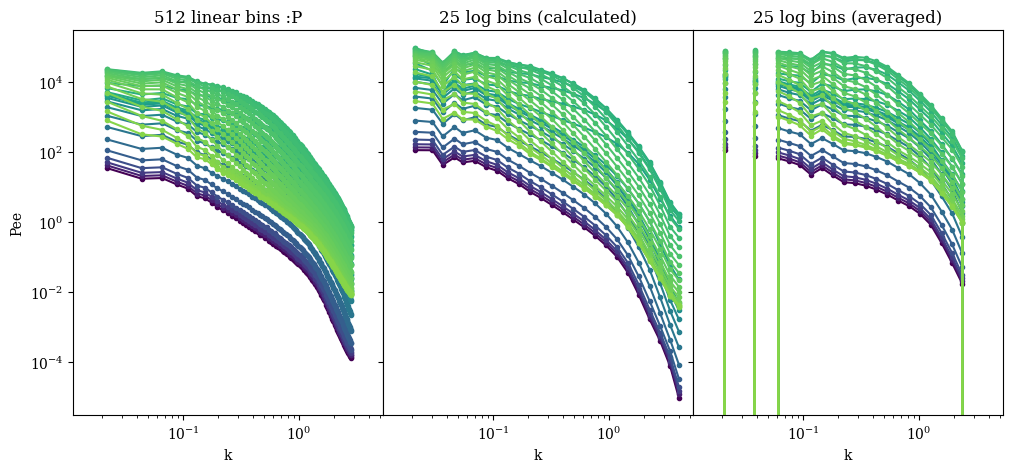

In [49]:
fig, ax = plt.subplots(1,3, figsize=(12,5), sharex=True, sharey=True)

for i in range(len(spectra)):
    ax[0].loglog(spectra[i][:,0] * .7, spectra[i][:,1] * (2 * np.pi**2) / spectra[i][:,0]**3,
                  color=cmap_z(norm_z(sim.z[i])), marker='.')
    ax[1].loglog(sim.k, sim.Pee[i],
                  color=cmap_z(norm_z(sim.z[i])), marker='.')
    ax[2].loglog(sim.k * .7, averaged_bins[i] * (2 * np.pi**2) / (sim.k * .7)**3,
                  color=cmap_z(norm_z(sim.z[i])), marker='.')
    
ax[0].set_title('512 linear bins :P')
ax[1].set_title('25 log bins (calculated)')
ax[2].set_title('25 log bins (averaged)')

[ax[i].set_xlabel('k') for i in range(3)]
ax[0].set_ylabel('Pee')

fig.subplots_adjust(wspace=0)

<<class 'astropy.constants.codata2018.CODATA2018'> name='Planck constant' value=6.62607015e-34 uncertainty=0.0 unit='J s' reference='CODATA 2018'>

In [48]:
sim.k / .7, spectra[0][:,0]

(array([0.03032425, 0.04288497, 0.05252315, 0.06637537, 0.07810928,
        0.09917125, 0.12491449, 0.1545804 , 0.19063649, 0.23879533,
        0.29711099, 0.36786396, 0.45774633, 0.5677805 , 0.70474831,
        0.87505503, 1.08591474, 1.34790953, 1.67308719, 2.07656322,
        2.57731645, 3.19867807, 3.94082325, 4.80866433, 5.71850525]),
 array([ 0.0314    ,  0.0628    ,  0.0942    ,  0.1256    ,  0.15700001,
         0.18840001,  0.21980001,  0.25120001,  0.28260001,  0.31400001,
         0.34540001,  0.37680001,  0.40820001,  0.43960001,  0.47100002,
         0.50240002,  0.53380002,  0.56520002,  0.59660002,  0.62800002,
         0.65940002,  0.69080002,  0.72220002,  0.75360003,  0.78500003,
         0.81640003,  0.84780003,  0.87920003,  0.91060003,  0.94200003,
         0.97340003,  1.00480003,  1.03620003,  1.06760004,  1.09900004,
         1.13040004,  1.16180004,  1.19320004,  1.22460004,  1.25600004,
         1.28740004,  1.31880004,  1.35020005,  1.38160005,  1.41300005,
 

Now we can plot all these things and look at them.

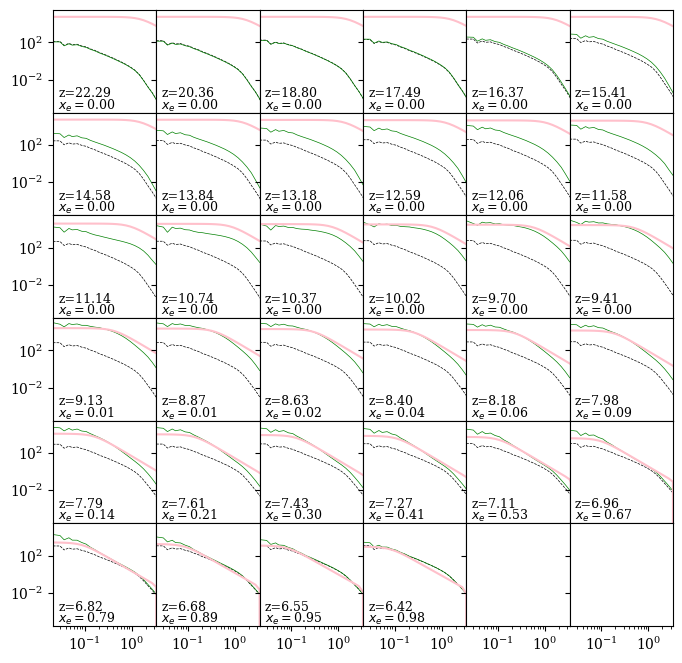

In [6]:
# DON'T FORGET TO CHANGE THE VARIABLES
sim_n = '10842'
fig, ax = plt.subplots(6,6, sharex=True, sharey=True, figsize=(8,8))

ax = ax.flatten()

# The LoReLi Pee spectra are stored in a dict per redshift,
# so we need to parse through it

for i, p in enumerate(simu10842.Pee):
    z = p['z']
    k = p['k'] # or you can just access this directly via the class variable simu10842.k
    pee = p['P_k']
    pbb = simu10842.Pbb[i]['P_k']
    xe = simu10842.xe[i]

    ax[i].annotate(f"z={z:.2f}", (0.05,.15), xycoords='axes fraction', fontsize=9)
    ax[i].annotate(rf"$x_e=${xe:.2f}", (0.05,.03), xycoords='axes fraction', fontsize=9)


    ax[i].loglog(k, pbb, color='black', alpha=1., ls='--', lw=.5)
    ax[i].loglog(k, pee, color='green', alpha=1., lw=.5)
    ax[i].loglog(k, G22.spectra[i], color='pink', alpha=1.) # The spectra shape is (z.size, k.size)


ax[0].set_xlim(simu10842.k[0], simu10842.k[-2])

fig.subplots_adjust(wspace=0, hspace=0)